# Predictive Analysis & Early Detection of Brain stroke using Machine Learning Algorithm

## Imports and Settings

In [419]:
## import all the necessary libraries
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns


In [420]:
# Import scikit-learn components
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    StratifiedKFold,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    f1_score,
    recall_score,
)
from sklearn.naive_bayes import GaussianNB, MultinomialNB

In [421]:
# Import imbalanced-learn components
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.metrics import classification_report_imbalanced


## Data Pre-processing

In [422]:
## Load the dataset
df = pd.read_csv("data.csv")

In [423]:
# Exploratory Data Analysis
print("Dataset shape:", df.shape)

Dataset shape: (3356, 11)


In [424]:
# Types of data
print("\nData types:")
print(df.dtypes)


Data types:
gender                object
age                    int64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object


In [425]:
# Display the missing values
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64



Class distribution:


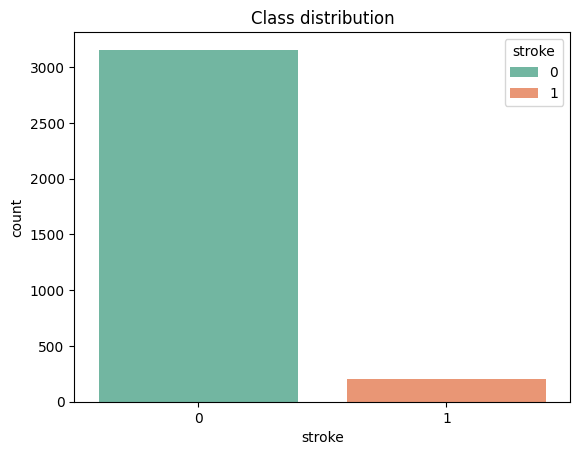

stroke
0    3155
1     201
Name: count, dtype: int64


In [426]:
print("\nClass distribution:")

sns.countplot(x="stroke", data=df, hue="stroke", palette="Set2")
plt.title("Class distribution")
plt.show()

print(df["stroke"].value_counts())

In [427]:
print(
    f"Imbalance ratio: 1:{df['stroke'].value_counts().iloc[0] / df['stroke'].value_counts().iloc[1]:.1f}"
)

Imbalance ratio: 1:15.7


In [428]:
# Check for non-numeric columns that might cause issues
unique_values_df = pd.DataFrame(
    {
        "Column Name": df.columns,
        "Unique Values": [
            df[col].unique()[:5] for col in df.columns
        ],  # Show first 5 unique values
    }
)

print(unique_values_df)

          Column Name                             Unique Values
0              gender                            [Male, Female]
1                 age                      [67, 80, 49, 79, 81]
2        hypertension                                    [0, 1]
3       heart_disease                                    [1, 0]
4        ever_married                                 [Yes, No]
5           work_type        [Private, Self-employed, Govt_job]
6      Residence_type                            [Urban, Rural]
7   avg_glucose_level  [228.69, 105.92, 171.23, 174.12, 186.21]
8                 bmi            [36.6, 32.5, 34.4, 24.0, 29.0]
9      smoking_status   [formerly smoked, never smoked, smokes]
10             stroke                                    [1, 0]


#### Fill Missing Values

##### For numerical columns

In [429]:
numerical_cols = ["age", "avg_glucose_level", "bmi"]
df.fillna({col: df[col].median() for col in numerical_cols}, inplace=True)

##### For Categorical Columns


In [430]:
categorical_cols = ["gender", "work_type", "Residence_type", "smoking_status"]
for col in categorical_cols:
    df.fillna({col: df[col].mode().iloc[0] for col in categorical_cols}, inplace=True)

#### Outlier Detection and Handling

In [431]:
def detect_and_handle_outliers(df, column):
    # Store original values for comparison
    original_values = df[column].copy()

    # Calculate bounds
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f"Number of outliers in {column}: {len(outliers)}")

    # Cap outliers
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])

    # Compare before and after statistics
    print(f"\nStatistics for {column} before vs after handling outliers:")
    compare_stats = pd.DataFrame(
        {"Before": original_values.describe(), "After": df[column].describe()}
    )
    print(compare_stats)

    # Only create visualizations for avg_glucose_level and bmi
    if column in ["avg_glucose_level", "bmi"]:
        # Create better-looking visualizations with side-by-side plots
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))

        # Box plots - Before
        sns.boxplot(x=original_values, color="skyblue", ax=axes[0, 0])
        axes[0, 0].set_title(f"Box Plot: {column} (Before)", fontsize=12)
        axes[0, 0].set_xlabel(f"{column} values")

        # Box plots - After
        sns.boxplot(x=df[column], color="lightgreen", ax=axes[0, 1])
        axes[0, 1].set_title(f"Box Plot: {column} (After)", fontsize=12)
        axes[0, 1].set_xlabel(f"{column} values")

        # Histograms - Before
        sns.histplot(original_values, kde=True, color="skyblue", ax=axes[1, 0])
        axes[1, 0].set_title(f"Distribution: {column} (Before)", fontsize=12)
        axes[1, 0].set_xlabel(f"{column} values")

        # Histograms - After
        sns.histplot(df[column], kde=True, color="lightgreen", ax=axes[1, 1])
        axes[1, 1].set_title(f"Distribution: {column} (After)", fontsize=12)
        axes[1, 1].set_xlabel(f"{column} values")

        plt.tight_layout()
        plt.show()

    return df

Number of outliers in age: 0

Statistics for age before vs after handling outliers:
            Before        After
count  3356.000000  3356.000000
mean     50.354291    50.354291
std      17.996007    17.996007
min      13.000000    13.000000
25%      36.000000    36.000000
50%      51.000000    51.000000
75%      64.000000    64.000000
max      82.000000    82.000000
Number of outliers in avg_glucose_level: 482

Statistics for avg_glucose_level before vs after handling outliers:
            Before        After
count  3356.000000  3356.000000
mean    109.179020   103.661674
std      48.619549    36.505869
min      55.120000    55.120000
25%      77.435000    77.435000
50%      92.540000    92.540000
75%     116.662500   116.662500
max     271.740000   175.503750


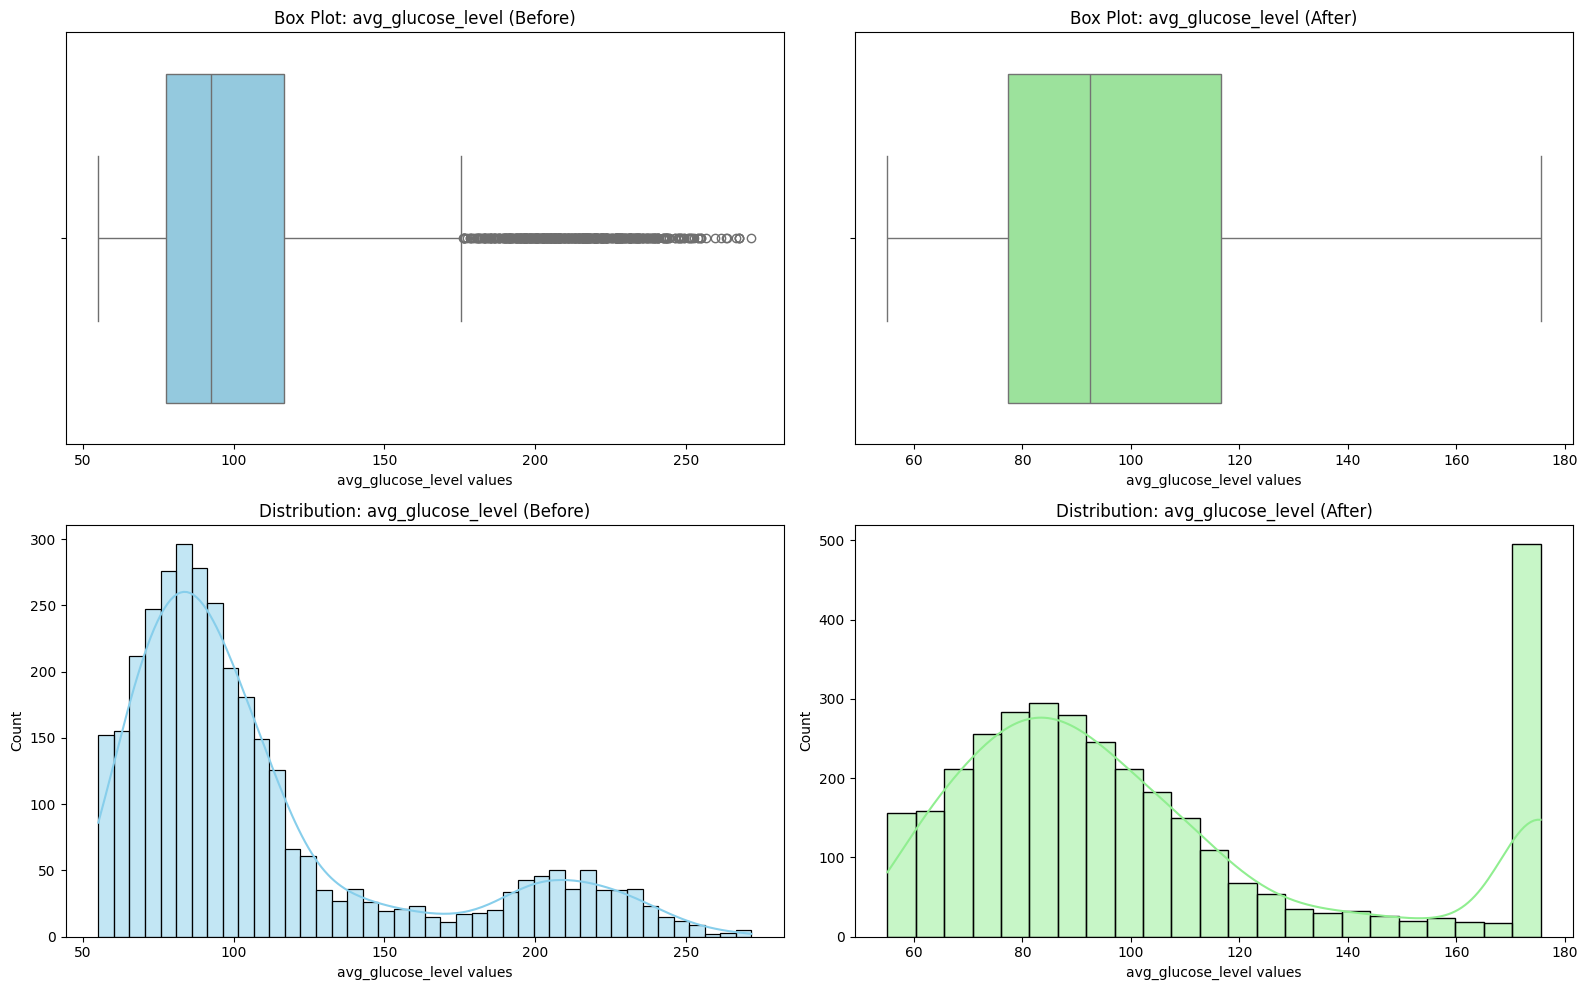

Number of outliers in bmi: 38

Statistics for bmi before vs after handling outliers:
            Before        After
count  3356.000000  3356.000000
mean     29.997259    29.977861
std       6.142134     6.088910
min      14.100000    14.100000
25%      25.600000    25.600000
50%      29.300000    29.300000
75%      33.600000    33.600000
max      48.900000    45.600000


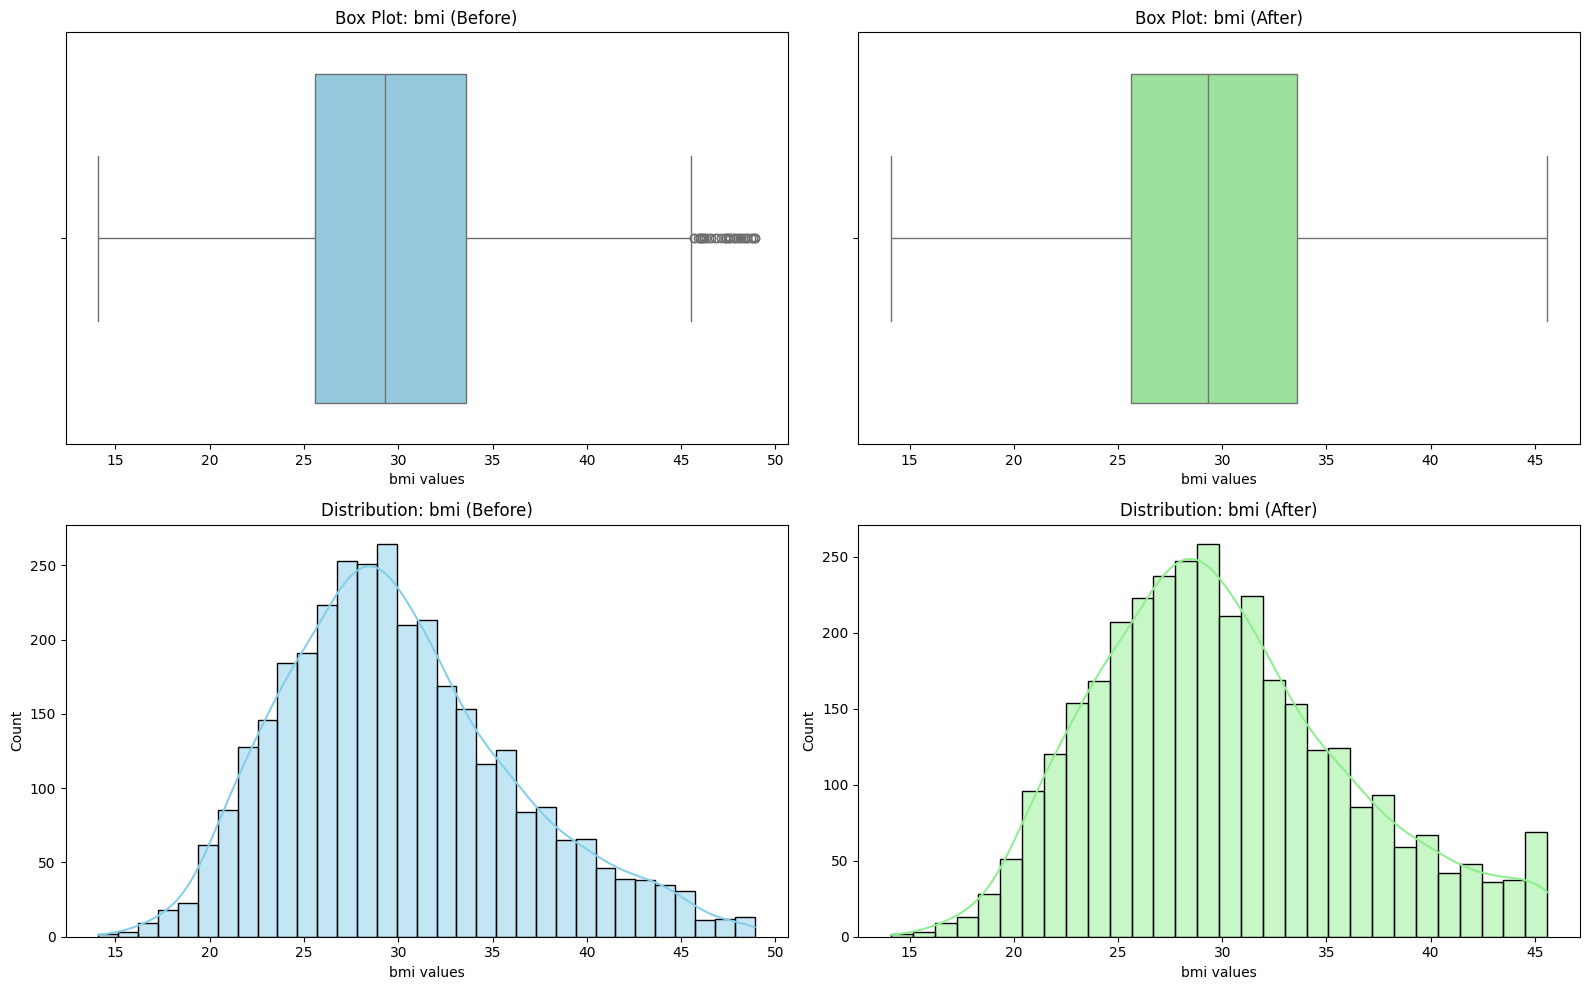

In [432]:
for col in numerical_cols:
    df = detect_and_handle_outliers(df, col)

In [433]:
object_columns = df.select_dtypes(include=["object"]).columns.tolist()
print(f"\nColumns with object dtype: {object_columns}")


Columns with object dtype: ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']


In [434]:
binary_columns = []
for col in df.columns:
    if df[col].dtype == "object":
        unique_vals = df[col].unique()
        if len(unique_vals) == 2 and set(unique_vals) == {"Yes", "No"}:
            binary_columns.append(col)
            df[col] = df[col].map({"Yes": 1, "No": 0})

In [435]:
le_dict = {}
for col in object_columns:
    if col not in binary_columns:  # Skip already converted binary columns
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        le_dict[col] = le  # Save encoder for future reference
        print(f"Encoded {col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")

Encoded gender: {'Female': np.int64(0), 'Male': np.int64(1)}
Encoded work_type: {'Govt_job': np.int64(0), 'Private': np.int64(1), 'Self-employed': np.int64(2)}
Encoded Residence_type: {'Rural': np.int64(0), 'Urban': np.int64(1)}
Encoded smoking_status: {'formerly smoked': np.int64(0), 'never smoked': np.int64(1), 'smokes': np.int64(2)}


In [436]:
for col in binary_columns:
    if col not in categorical_cols and col != "stroke":
        categorical_cols.append(col)

In [437]:
# Convert categorical variables to numerical using Label Encoding
print("\n--- Converting Categorical Data to Numerical ---")
le_dict = {}
for col in categorical_cols:
    if df[col].dtype == "object":  # Only encode columns that are still objects
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        le_dict[col] = le  # Save encoder for future reference
        print(f"Encoded {col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")



--- Converting Categorical Data to Numerical ---


In [438]:
remaining_objects = df.select_dtypes(include=["object"]).columns.tolist()
if remaining_objects:
    print(
        f"\nWARNING: Still have object columns that need conversion: {remaining_objects}"
    )
    for col in remaining_objects:
        print(f"Values in {col}: {df[col].unique()}")
        if col != "stroke":  # Don't convert the target if it's already numeric
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
            print(f"Encoded {col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")

In [439]:
df = df.apply(pd.to_numeric, errors="coerce")

In [440]:
if df.isnull().sum().sum() > 0:
    print(
        "\nWARNING: NaN values found after conversion. Filling with appropriate values."
    )
    df = df.fillna(df.mean())


BMI after log transformation:
count    3356.000000
mean        3.414224
std         0.195271
min         2.714695
25%         3.280911
50%         3.411148
75%         3.543854
max         3.841601
Name: bmi_log, dtype: float64


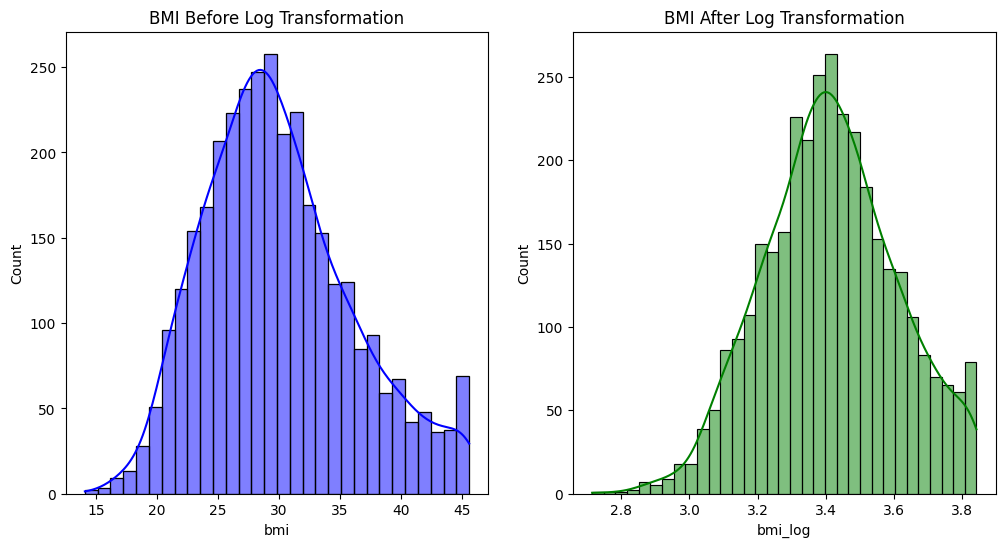

In [441]:
# Apply log transformation to BMI to handle skewness
df["bmi_log"] = np.log(df["bmi"] + 1)  # Add 1 to avoid log(0)
print("\nBMI after log transformation:")
print(df["bmi_log"].describe())

# Visualize BMI before and after log transformation
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df["bmi"], kde=True, color="blue")
plt.title("BMI Before Log Transformation")

plt.subplot(1, 2, 2)
sns.histplot(df["bmi_log"], kde=True, color="green")
plt.title("BMI After Log Transformation")
plt.show()

In [442]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(df.drop("stroke", axis=1), df["stroke"])
df_resampled = pd.DataFrame(X_resampled, columns=df.drop("stroke", axis=1).columns)
df_resampled["stroke"] = y_resampled

In [443]:
scaler = StandardScaler()
numerical_cols = ["age", "avg_glucose_level", "bmi_log"]  # Include the transformed BMI
df_resampled[numerical_cols] = scaler.fit_transform(df_resampled[numerical_cols])


Correlation Matrix (After Resampling and Scaling):
                     gender       age  hypertension  heart_disease  \
gender             1.000000 -0.073690      0.025608       0.113804   
age               -0.073690  1.000000      0.141612       0.160378   
hypertension       0.025608  0.141612      1.000000       0.059274   
heart_disease      0.113804  0.160378      0.059274       1.000000   
ever_married       0.043370  0.236079      0.057609       0.029269   
work_type          0.042359  0.073075      0.035350       0.006147   
Residence_type     0.039609 -0.107977     -0.014041       0.059619   
avg_glucose_level  0.036260  0.220499      0.105695       0.180412   
bmi                0.049213 -0.044156      0.060535       0.032366   
smoking_status     0.030356 -0.291948      0.018968       0.014588   
bmi_log            0.063615 -0.024084      0.061123       0.040491   
stroke            -0.185091  0.546652     -0.013566       0.017500   

                   ever_married  work

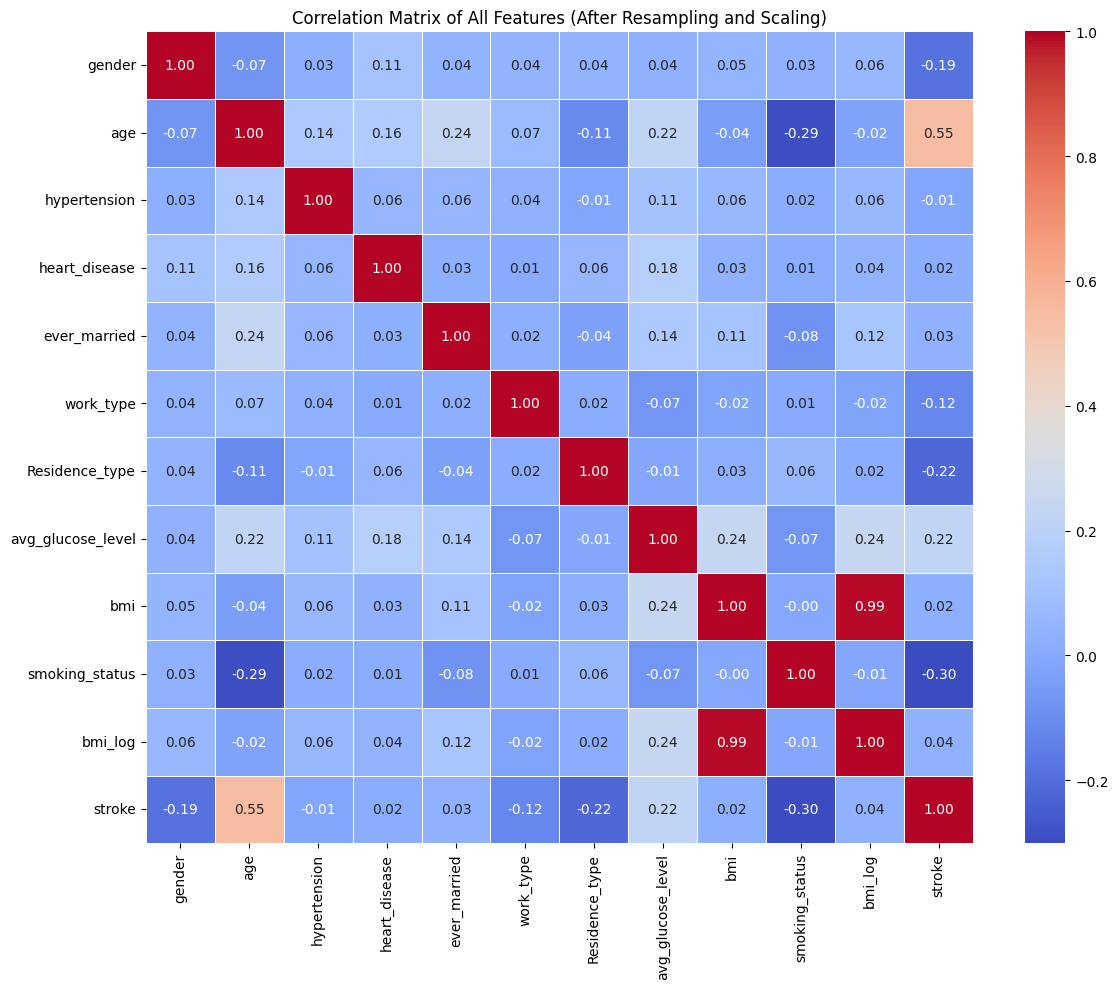


Feature Correlation with Target (stroke):
stroke               1.000000
age                  0.546652
avg_glucose_level    0.218437
bmi_log              0.037451
ever_married         0.030284
bmi                  0.020401
heart_disease        0.017500
hypertension        -0.013566
work_type           -0.119020
gender              -0.185091
Residence_type      -0.217023
smoking_status      -0.301029
Name: stroke, dtype: float64


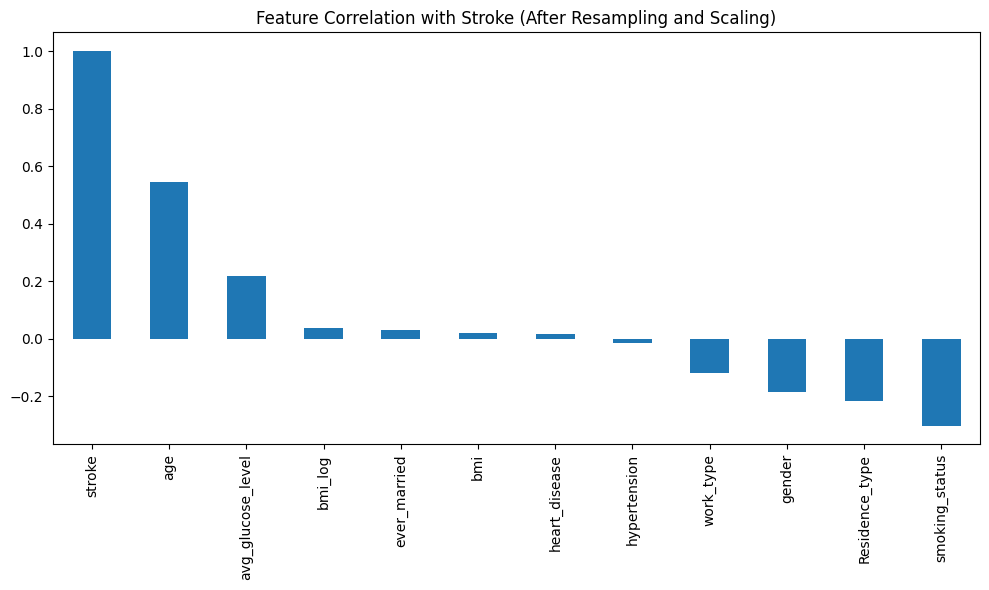

In [444]:
correlation_matrix = df_resampled.corr()
print("\nCorrelation Matrix (After Resampling and Scaling):")
print(correlation_matrix)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of All Features (After Resampling and Scaling)")
plt.tight_layout()
plt.savefig("correlation_matrix_resampled_scaled.png")
plt.show()

target_correlation = correlation_matrix["stroke"].sort_values(ascending=False)
print("\nFeature Correlation with Target (stroke):")
print(target_correlation)

plt.figure(figsize=(10, 6))
target_correlation.plot(kind="bar")
plt.title("Feature Correlation with Stroke (After Resampling and Scaling)")
plt.tight_layout()
plt.savefig("target_correlation_resampled_scaled.png")
plt.show()

In [445]:
print("\n--- Correlation Analysis ---")
correlation_matrix = df.corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)


--- Correlation Analysis ---

Correlation Matrix:
                     gender       age  hypertension  heart_disease  \
gender             1.000000  0.054409      0.039240       0.105116   
age                0.054409  1.000000      0.263208       0.264274   
hypertension       0.039240  0.263208      1.000000       0.106545   
heart_disease      0.105116  0.264274      0.106545       1.000000   
ever_married       0.031101  0.455015      0.098388       0.065754   
work_type         -0.016945  0.184268      0.053014       0.045377   
Residence_type    -0.011473  0.015428     -0.008008       0.013915   
avg_glucose_level  0.065630  0.205656      0.150085       0.141143   
bmi                0.044057  0.058448      0.112327       0.009652   
smoking_status    -0.026928 -0.165164     -0.017417      -0.017908   
stroke             0.016907  0.251507      0.136541       0.127033   
bmi_log            0.063250  0.076977      0.116474       0.019167   

                   ever_married  work_

In [446]:
target_correlation = correlation_matrix["stroke"].sort_values(ascending=True)
print("\nFeature Correlation with Target (stroke):")
print(target_correlation)


Feature Correlation with Target (stroke):
smoking_status      -0.041860
Residence_type       0.007949
bmi                  0.016243
gender               0.016907
bmi_log              0.020811
work_type            0.052216
ever_married         0.065126
avg_glucose_level    0.117847
heart_disease        0.127033
hypertension         0.136541
age                  0.251507
stroke               1.000000
Name: stroke, dtype: float64


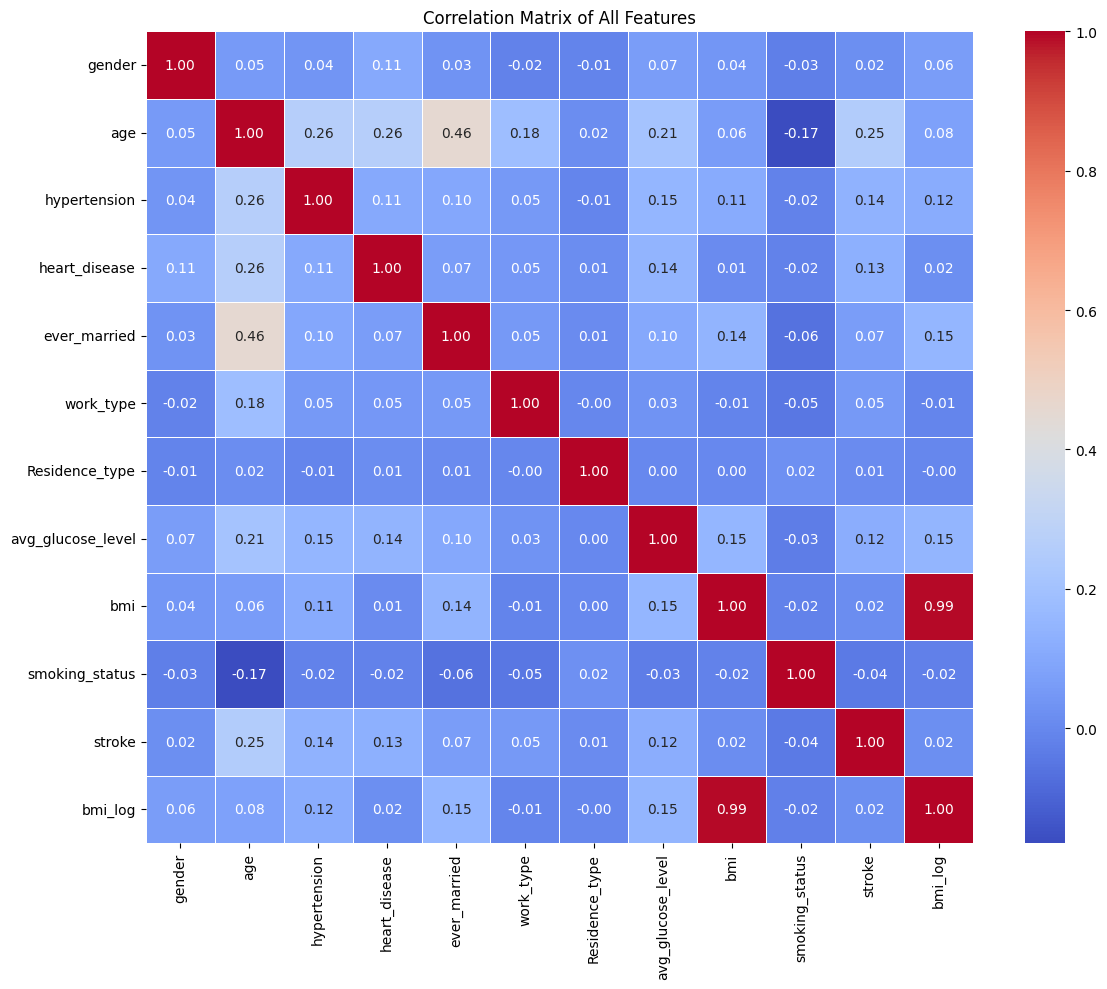

In [447]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of All Features")
plt.tight_layout()
plt.savefig("correlation_matrix.png")
plt.show()

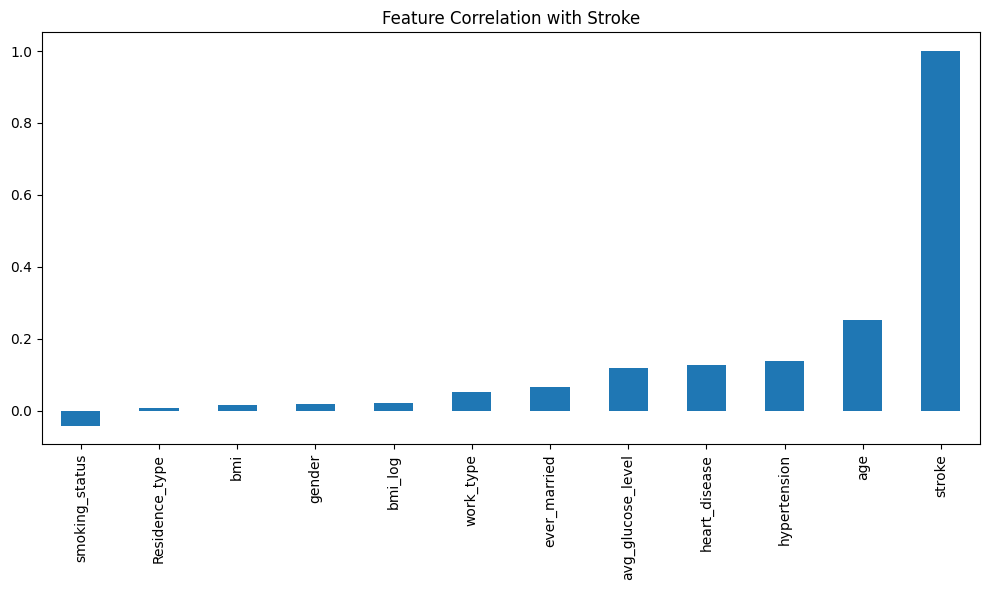

In [448]:
plt.figure(figsize=(10, 6))
target_correlation.plot(kind="bar")
plt.title("Feature Correlation with Stroke")
plt.tight_layout()
plt.savefig("target_correlation.png")
plt.show()

In [449]:
df["bmi_category"] = pd.cut(
    df["bmi"], bins=[0, 18.5, 25, 30, 100], labels=[0, 1, 2, 3]
)  # Underweight, Normal, Overweight, Obese

# Create glucose level categories
df["glucose_category"] = pd.cut(
    df["avg_glucose_level"], bins=[0, 100, 125, 200, 500], labels=[0, 1, 2, 3]
)  # Normal, Prediabetes, Diabetes, High

# Create age groups
df["age_group"] = pd.cut(
    df["age"], bins=[0, 18, 40, 60, 100], labels=[0, 1, 2, 3]
)  # Child, Young Adult, Middle Age, Senior


In [450]:
new_cats = ["bmi_category", "glucose_category", "age_group"]
for col in new_cats:
    if df[col].dtype != "int64":
        df[col] = df[col].astype("int64")

In [451]:
# Recalculate correlation after feature engineering
print("\n--- Correlation After Feature Engineering ---")
correlation_after_fe = df.corr()["stroke"].sort_values(ascending=False)
print(correlation_after_fe)


--- Correlation After Feature Engineering ---
stroke               1.000000
age                  0.251507
age_group            0.218616
hypertension         0.136541
heart_disease        0.127033
avg_glucose_level    0.117847
glucose_category     0.107291
ever_married         0.065126
work_type            0.052216
bmi_log              0.020811
bmi_category         0.020130
gender               0.016907
bmi                  0.016243
Residence_type       0.007949
smoking_status      -0.041860
Name: stroke, dtype: float64


In [452]:
# Find features with correlation greater than 0.8
columns_to_drop = ["Residence_type", "ever_married", "work_type"]
# Drop highly correlated features
df.drop(columns_to_drop, axis=1, inplace=True)
print(f"\nDropped columns due to high correlation: {columns_to_drop}")


Dropped columns due to high correlation: ['Residence_type', 'ever_married', 'work_type']


In [453]:
# Choose which scaling method to use
scaling_method = "minmax"  # Options: 'standard', 'minmax'
scaling_range = "single"  # Options: 'single', 'double'

if scaling_method == "standard":
    scaler = StandardScaler()
elif scaling_method == "minmax":
    if scaling_range == "single":
        scaler = MinMaxScaler(feature_range=(0, 9))
    else:  # double digit
        scaler = MinMaxScaler(feature_range=(0, 99))

# Apply scaling to numerical features
scaled_features = scaler.fit_transform(df[numerical_cols])
df[numerical_cols] = scaled_features

In [454]:
X = df.drop("stroke", axis=1)
y = df["stroke"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#### Advanced Resampling with imbalanced-learn
##### Evaluate different resampling strategies
##### Define resampling methods to test

In [455]:
resampling_methods = {
    "No resampling": None,
    "SMOTE": SMOTE(random_state=42),
    "BorderlineSMOTE": BorderlineSMOTE(random_state=42),
    "ADASYN": ADASYN(random_state=42),
    "RandomUnderSampler": RandomUnderSampler(random_state=42),
    "ClusterCentroids": ClusterCentroids(random_state=42),
    "SMOTETomek": SMOTETomek(random_state=42),
    "SMOTEENN": SMOTEENN(random_state=42),
}

##### Test each resampling method with a baseline model

In [456]:
baseline_model = RandomForestClassifier(n_estimators=100, random_state=42)
resampling_results = []

for name, method in resampling_methods.items():
    print(f"\nEvaluating resampling method: {name}")

    # Create a resampling pipeline if method is not None
    if method is not None:
        pipeline = ImbPipeline([("resampler", method), ("classifier", baseline_model)])

        # Fit the pipeline
        pipeline.fit(X_train, y_train)

        # Make predictions
        y_pred = pipeline.predict(X_test)

        # Get class distribution after resampling
        X_resampled, y_resampled = method.fit_resample(X_train, y_train)
        pos_count = sum(y_resampled == 1)
        neg_count = sum(y_resampled == 0)

    else:
        # No resampling
        baseline_model.fit(X_train, y_train)
        y_pred = baseline_model.predict(X_test)
        pos_count = sum(y_train == 1)
        neg_count = sum(y_train == 0)

    # Calculate metrics
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    print(
        f"Class distribution after resampling - Positive: {pos_count}, Negative: {neg_count}, Ratio: 1:{neg_count / pos_count:.1f}"
    )
    print(f"F1 Score: {f1:.4f}, Recall: {recall:.4f}")

    resampling_results.append(
        {
            "Method": name,
            "F1 Score": f1,
            "Recall": recall,
            "Pos Count": pos_count,
            "Neg Count": neg_count,
            "Ratio": neg_count / pos_count,
        }
    )


Evaluating resampling method: No resampling
Class distribution after resampling - Positive: 161, Negative: 2523, Ratio: 1:15.7
F1 Score: 0.0000, Recall: 0.0000

Evaluating resampling method: SMOTE
Class distribution after resampling - Positive: 2523, Negative: 2523, Ratio: 1:1.0
F1 Score: 0.1468, Recall: 0.2000

Evaluating resampling method: BorderlineSMOTE
Class distribution after resampling - Positive: 2523, Negative: 2523, Ratio: 1:1.0
F1 Score: 0.2083, Recall: 0.2500

Evaluating resampling method: ADASYN
Class distribution after resampling - Positive: 2526, Negative: 2523, Ratio: 1:1.0
F1 Score: 0.1538, Recall: 0.2000

Evaluating resampling method: RandomUnderSampler
Class distribution after resampling - Positive: 161, Negative: 161, Ratio: 1:1.0
F1 Score: 0.1969, Recall: 0.6250

Evaluating resampling method: ClusterCentroids
Class distribution after resampling - Positive: 161, Negative: 161, Ratio: 1:1.0
F1 Score: 0.1489, Recall: 0.8750

Evaluating resampling method: SMOTETomek
C

In [457]:
# Convert results to DataFrame and find best method
resampling_df = pd.DataFrame(resampling_results)
print("\nResampling method comparison:")
print(resampling_df)

# Select best resampling method based on F1 score
best_resampling_method_name = resampling_df.loc[
    resampling_df["F1 Score"].idxmax(), "Method"
]
best_resampling_method = resampling_methods[best_resampling_method_name]
print(f"\nBest resampling method: {best_resampling_method_name}")

# Apply the best resampling method
if best_resampling_method is not None:
    X_resampled, y_resampled = best_resampling_method.fit_resample(X_train, y_train)
    print(
        f"Resampled class distribution - Positive: {sum(y_resampled == 1)}, Negative: {sum(y_resampled == 0)}"
    )
else:
    X_resampled, y_resampled = X_train, y_train



Resampling method comparison:
               Method  F1 Score  Recall  Pos Count  Neg Count      Ratio
0       No resampling  0.000000   0.000        161       2523  15.670807
1               SMOTE  0.146789   0.200       2523       2523   1.000000
2     BorderlineSMOTE  0.208333   0.250       2523       2523   1.000000
3              ADASYN  0.153846   0.200       2526       2523   0.998812
4  RandomUnderSampler  0.196850   0.625        161        161   1.000000
5    ClusterCentroids  0.148936   0.875        161        161   1.000000
6          SMOTETomek  0.200000   0.275       2506       2506   1.000000
7            SMOTEENN  0.216495   0.525       2401       1867   0.777593

Best resampling method: SMOTEENN
Resampled class distribution - Positive: 2401, Negative: 1867


In [458]:
# 3.1 Define parameter grids for each model
param_grids = {
    "KNN": {
        "n_neighbors": [3, 5, 7, 9, 11, 13],
        "weights": ["uniform", "distance"],
        "metric": ["euclidean", "manhattan", "minkowski"],
        "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
    },
    "RandomForest": {
        "n_estimators": [100, 200, 300],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "class_weight": ["balanced", "balanced_subsample", None],
    },
    "DecisionTree": {
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "criterion": ["gini", "entropy"],
        "class_weight": ["balanced", None],
    },
    "GaussianNB": {"var_smoothing": [1e-9, 1e-8, 1e-7, 1e-6]},
    "MultinomialNB": {"alpha": [0.1, 0.5, 1.0, 2.0], "fit_prior": [True, False]},
}

In [459]:
models = {
    "KNN": KNeighborsClassifier(),
    "RandomForest": RandomForestClassifier(random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "GaussianNB": GaussianNB(),
    "MultinomialNB": MultinomialNB(),
}

best_models = {}
best_scores = {}

In [460]:
for name, model in models.items():
    print(f"\nTraining and tuning {name}...")

    # Use RandomizedSearchCV for faster hyperparameter tuning
    search = RandomizedSearchCV(
        model,
        param_grids[name],
        n_iter=20,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring="f1",
        n_jobs=-1,
        random_state=42,
    )

    # Fit the model
    search.fit(X_resampled, y_resampled)

    # Save the best model
    best_models[name] = search.best_estimator_
    best_scores[name] = search.best_score_

    print(f"Best parameters: {search.best_params_}")
    print(f"Best cross-validation score: {search.best_score_:.4f}")



Training and tuning KNN...
Best parameters: {'weights': 'distance', 'n_neighbors': 3, 'metric': 'minkowski', 'algorithm': 'kd_tree'}
Best cross-validation score: 0.9736

Training and tuning RandomForest...
Best parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'class_weight': 'balanced_subsample'}
Best cross-validation score: 0.9747

Training and tuning DecisionTree...
Best parameters: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'criterion': 'gini', 'class_weight': 'balanced'}
Best cross-validation score: 0.9450

Training and tuning GaussianNB...
Best parameters: {'var_smoothing': 1e-09}
Best cross-validation score: 0.8203

Training and tuning MultinomialNB...
Best parameters: {'fit_prior': True, 'alpha': 0.1}
Best cross-validation score: 0.8177


c:\Ml\Predictive Analysis & Early Detection of Brain stroke using Machine Learning Algorithm\venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=20. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Ml\Predictive Analysis & Early Detection of Brain stroke using Machine Learning Algorithm\venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



KNN Results:
              precision    recall  f1-score   support

           0       0.96      0.69      0.81       632
           1       0.10      0.55      0.17        40

    accuracy                           0.69       672
   macro avg       0.53      0.62      0.49       672
weighted avg       0.91      0.69      0.77       672

Imbalanced Classification Report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.96      0.69      0.55      0.81      0.62      0.39       632
          1       0.10      0.55      0.69      0.17      0.62      0.38        40

avg / total       0.91      0.69      0.56      0.77      0.62      0.39       672



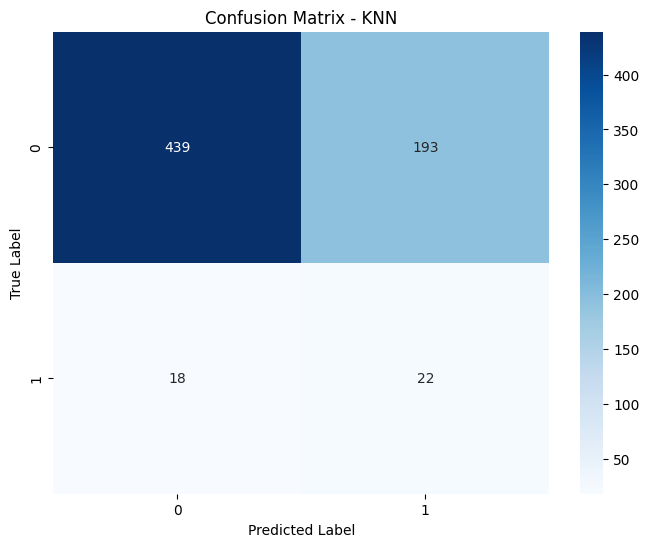

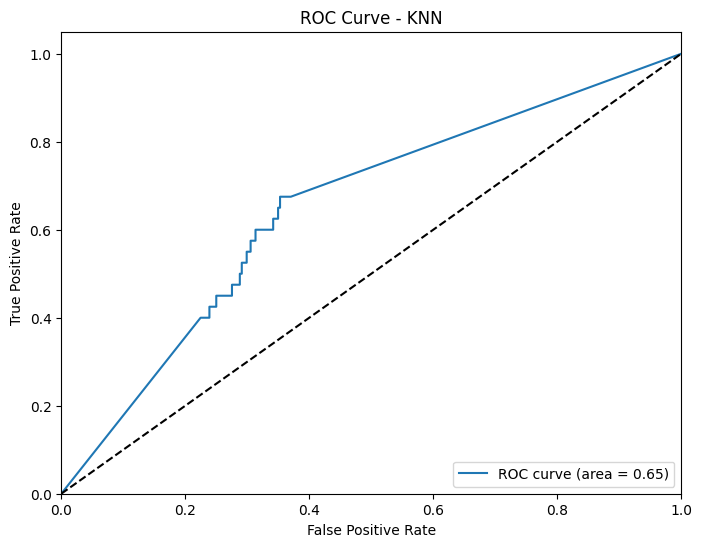

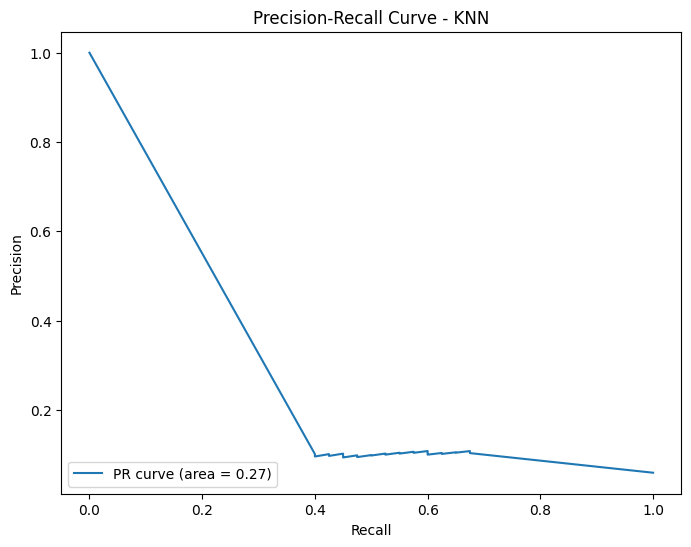


RandomForest Results:
              precision    recall  f1-score   support

           0       0.96      0.79      0.87       632
           1       0.13      0.53      0.21        40

    accuracy                           0.77       672
   macro avg       0.55      0.66      0.54       672
weighted avg       0.91      0.77      0.83       672

Imbalanced Classification Report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.96      0.79      0.53      0.87      0.64      0.42       632
          1       0.13      0.53      0.79      0.21      0.64      0.40        40

avg / total       0.91      0.77      0.54      0.83      0.64      0.42       672



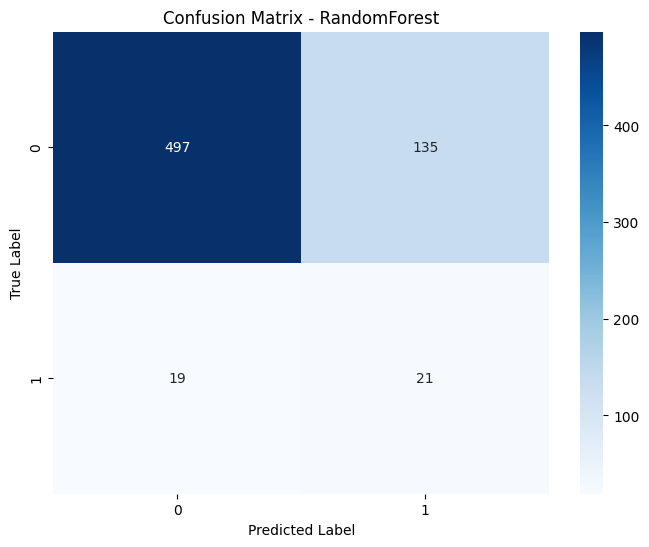

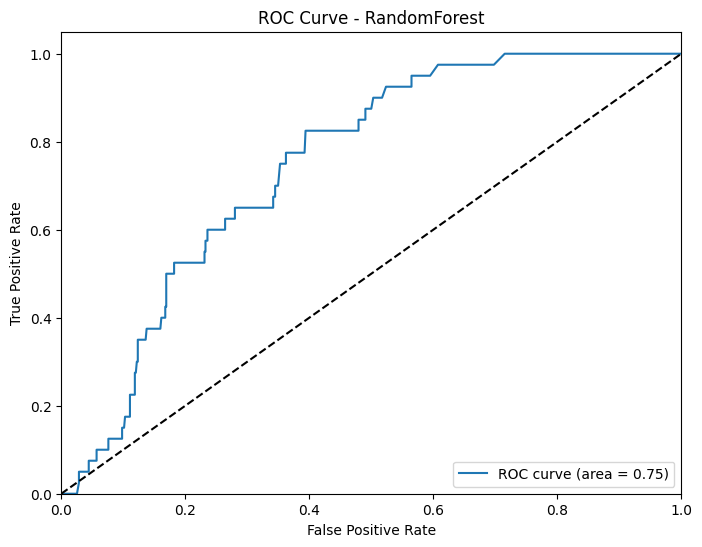

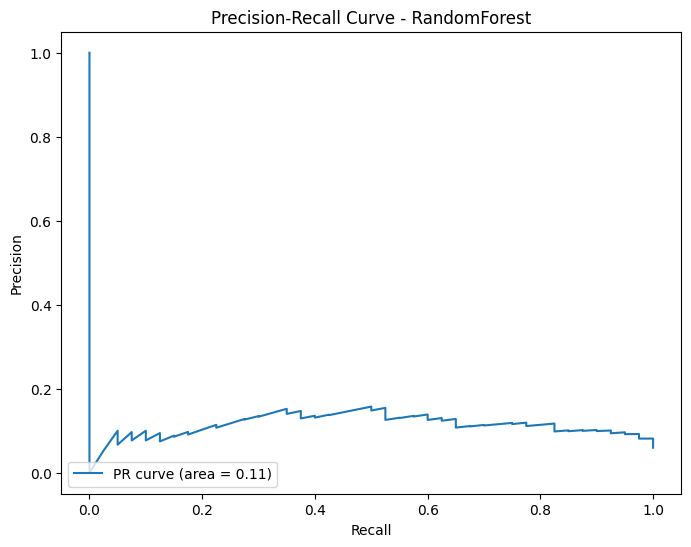


DecisionTree Results:
              precision    recall  f1-score   support

           0       0.95      0.78      0.86       632
           1       0.10      0.38      0.16        40

    accuracy                           0.76       672
   macro avg       0.53      0.58      0.51       672
weighted avg       0.90      0.76      0.82       672

Imbalanced Classification Report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.78      0.38      0.86      0.54      0.31       632
          1       0.10      0.38      0.78      0.16      0.54      0.28        40

avg / total       0.90      0.76      0.40      0.82      0.54      0.30       672



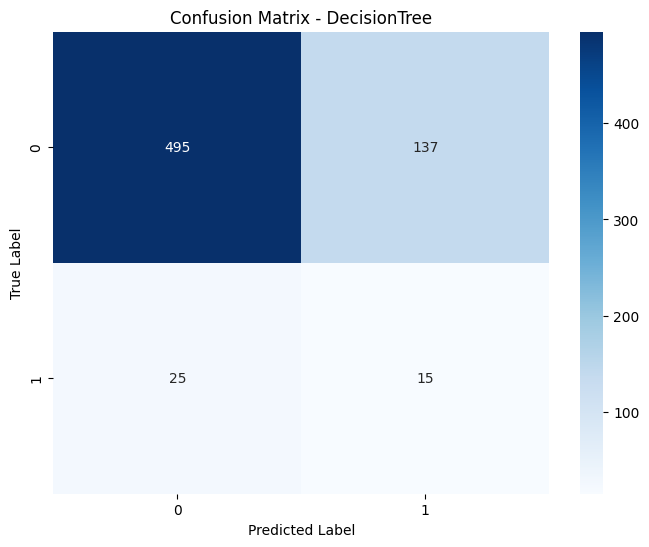

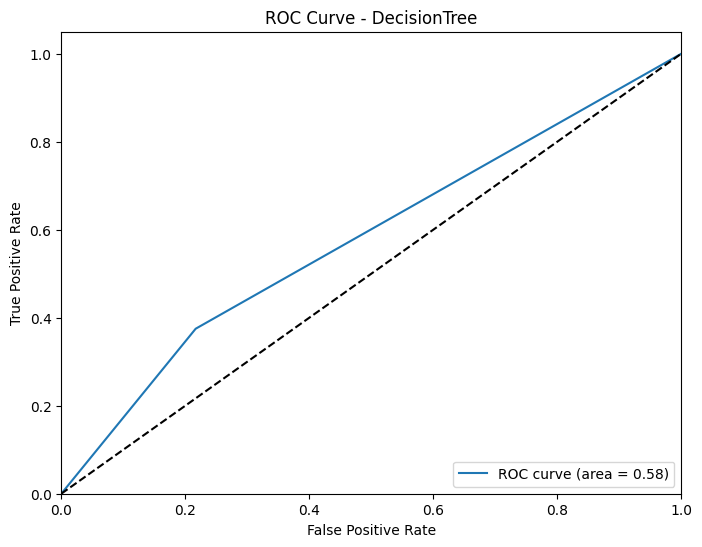

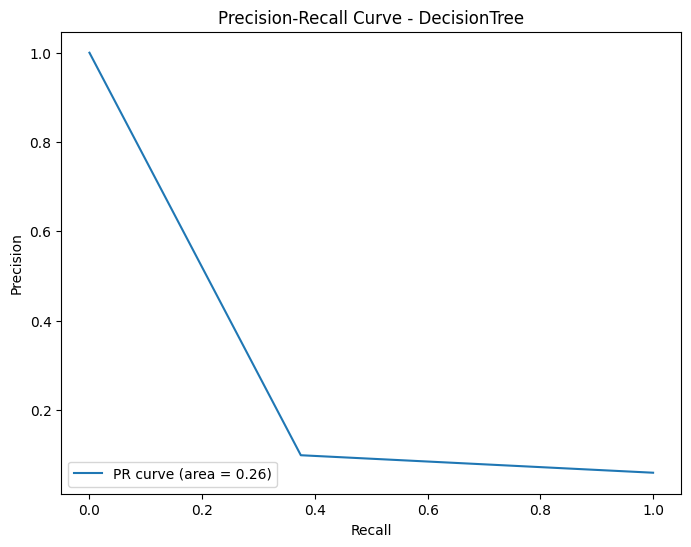


GaussianNB Results:
              precision    recall  f1-score   support

           0       0.99      0.62      0.76       632
           1       0.13      0.88      0.22        40

    accuracy                           0.63       672
   macro avg       0.56      0.75      0.49       672
weighted avg       0.94      0.63      0.73       672

Imbalanced Classification Report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.62      0.88      0.76      0.73      0.53       632
          1       0.13      0.88      0.62      0.22      0.73      0.55        40

avg / total       0.94      0.63      0.86      0.73      0.73      0.53       672



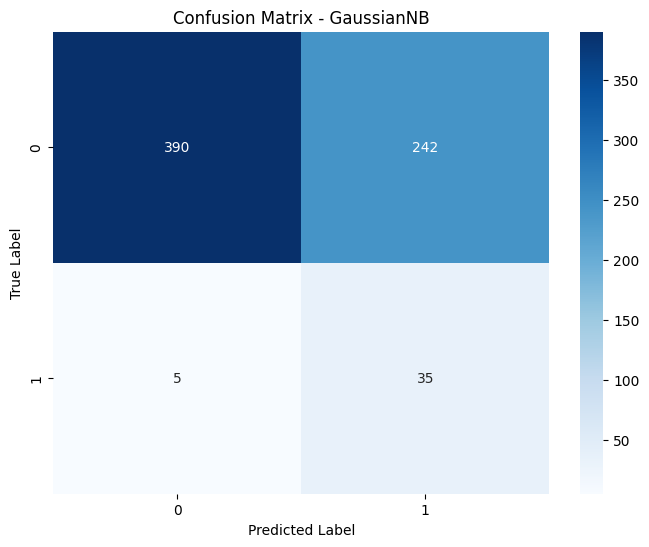

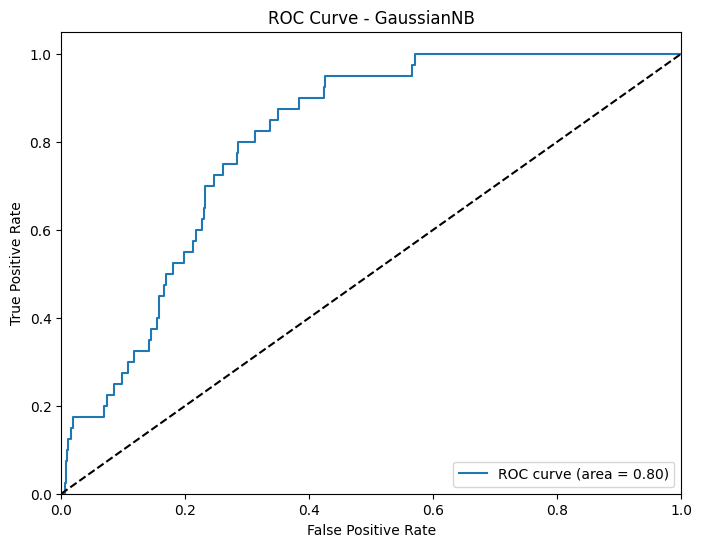

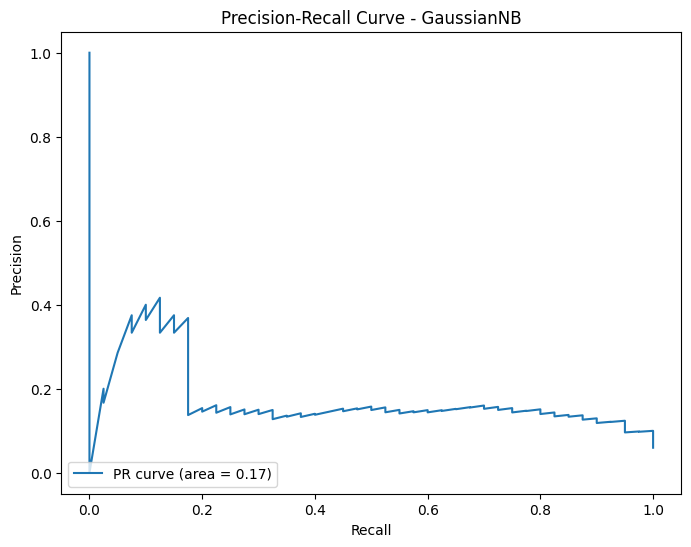


MultinomialNB Results:
              precision    recall  f1-score   support

           0       0.98      0.60      0.75       632
           1       0.11      0.80      0.20        40

    accuracy                           0.61       672
   macro avg       0.55      0.70      0.47       672
weighted avg       0.93      0.61      0.71       672

Imbalanced Classification Report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.60      0.80      0.75      0.69      0.47       632
          1       0.11      0.80      0.60      0.20      0.69      0.49        40

avg / total       0.93      0.61      0.79      0.71      0.69      0.47       672



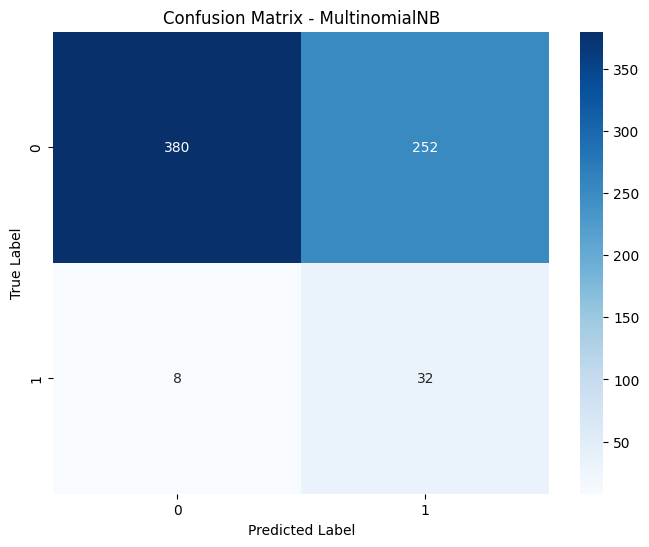

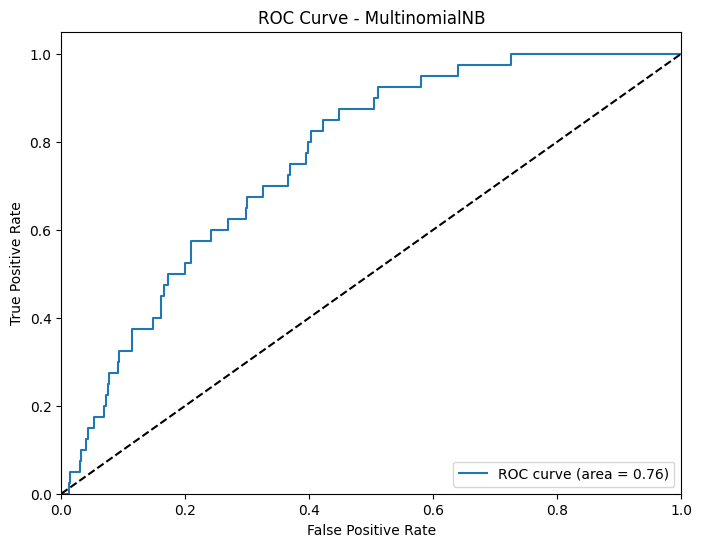

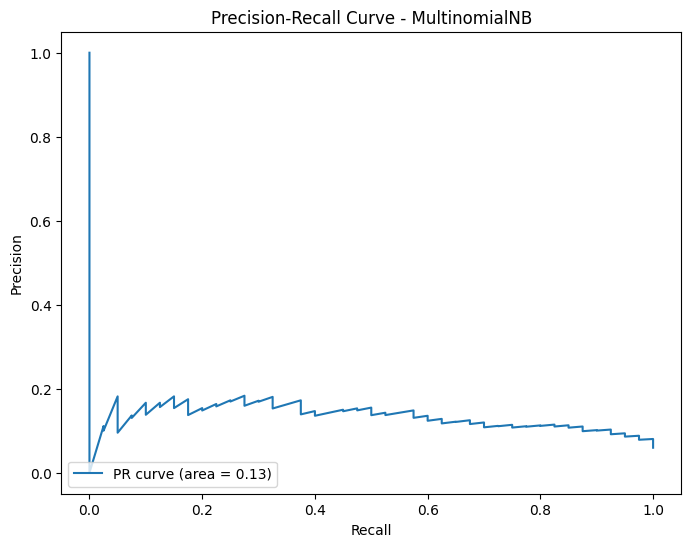

In [461]:
model_results = []

for name, model in best_models.items():
    # Make predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    # Calculate ROC-AUC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Calculate PR-AUC
    precision, recall_curve, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall_curve, precision)

    model_results.append(
        {
            "Model": name,
            "F1 Score": f1,
            "Recall": recall,
            "ROC-AUC": roc_auc,
            "PR-AUC": pr_auc,
        }
    )

    # Print classification report
    print(f"\n{name} Results:")
    print(classification_report(y_test, y_pred))

    # Print imbalanced classification report
    print("Imbalanced Classification Report:")
    print(classification_report_imbalanced(y_test, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.savefig(f"confusion_matrix_{name}.png")
    plt.show()

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name}")
    plt.legend(loc="lower right")
    plt.savefig(f"roc_curve_{name}.png")
    plt.show()

    # Plot Precision-Recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall_curve, precision, label=f"PR curve (area = {pr_auc:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve - {name}")
    plt.legend(loc="lower left")
    plt.savefig(f"pr_curve_{name}.png")
    plt.show()

In [462]:
model_results_df = pd.DataFrame(model_results)
print("\nModel Comparison:")
print(model_results_df)


Model Comparison:
           Model  F1 Score  Recall   ROC-AUC    PR-AUC
0            KNN  0.172549   0.550  0.649763  0.274623
1   RandomForest  0.214286   0.525  0.748477  0.112736
2   DecisionTree  0.156250   0.375  0.579114  0.255443
3     GaussianNB  0.220820   0.875  0.802690  0.169399
4  MultinomialNB  0.197531   0.800  0.761195  0.131663


In [463]:
best_model_name = model_results_df.loc[model_results_df["PR-AUC"].idxmax(), "Model"]
best_model = best_models[best_model_name]
print(f"\nBest model based on PR-AUC: {best_model_name}")


Best model based on PR-AUC: KNN


In [464]:
# 5. Feature Importance Analysis for the best model
if best_model_name in ["RandomForest", "DecisionTree"]:
    # For tree-based models, we can directly get feature importance
    feature_importance = pd.DataFrame(
        {"Feature": X.columns, "Importance": best_model.feature_importances_}
    ).sort_values("Importance", ascending=False)

    print("\nFeature Importance:")
    print(feature_importance)

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x="Importance", y="Feature", data=feature_importance)
    plt.title(f"Feature Importance ({best_model_name})")
    plt.tight_layout()
    plt.savefig("feature_importance.png")
    plt.show()

In [465]:
import joblib

joblib.dump(best_model, f"stroke_prediction_{best_model_name}.pkl")
print(f"\nBest model saved as: stroke_prediction_{best_model_name}.pkl")

# 7. Final summary
print("\n=== STROKE PREDICTION MODEL SUMMARY ===")
print(f"Best model: {best_model_name}")
print(
    f"Best model PR-AUC: {model_results_df.loc[model_results_df['Model'] == best_model_name, 'PR-AUC'].values[0]:.4f}"
)
print(
    f"Best model F1 Score: {model_results_df.loc[model_results_df['Model'] == best_model_name, 'F1 Score'].values[0]:.4f}"
)
print(
    f"Best model Recall: {model_results_df.loc[model_results_df['Model'] == best_model_name, 'Recall'].values[0]:.4f}"
)
print(f"Best resampling method: {best_resampling_method_name}")
print("=== CATEGORICAL DATA CONVERSION SUMMARY ===")
for col in categorical_cols:
    print(f"- {col}: Converted to numerical values")
print("=== TOP CORRELATED FEATURES WITH STROKE ===")
print(target_correlation.head(5))


Best model saved as: stroke_prediction_KNN.pkl

=== STROKE PREDICTION MODEL SUMMARY ===
Best model: KNN
Best model PR-AUC: 0.2746
Best model F1 Score: 0.1725
Best model Recall: 0.5500
Best resampling method: SMOTEENN
=== CATEGORICAL DATA CONVERSION SUMMARY ===
- gender: Converted to numerical values
- work_type: Converted to numerical values
- Residence_type: Converted to numerical values
- smoking_status: Converted to numerical values
- ever_married: Converted to numerical values
=== TOP CORRELATED FEATURES WITH STROKE ===
smoking_status   -0.041860
Residence_type    0.007949
bmi               0.016243
gender            0.016907
bmi_log           0.020811
Name: stroke, dtype: float64
